<a href="https://colab.research.google.com/github/PedroHenrique726/Analise-de-dados-de-teste-de-performance/blob/main/Analise_dos_testes_de_performance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install pandas

In [2]:
import pandas as pd

# Carregar o arquivo Excel usando pandas
caminho_arquivo_excel_1 = '/content/QuintoTestLoad.xlsx'
dados_df = pd.read_excel(caminho_arquivo_excel_1, engine='openpyxl')




In [3]:
nome_coluna_timestamp = 'timeStamp'

# Converter a coluna 'timeStamp' para datetime ou período, unidade 'ms', com tratamento de erros 'coerce'
dados_df['timeStamp'] = pd.to_datetime(dados_df[nome_coluna_timestamp], unit='ms', errors='coerce')

# Filtrar apenas as linhas do ano de 2023
dados_df = dados_df[pd.DatetimeIndex(dados_df['timeStamp']).year == 2023]

# Remover o offset de fuso horário e manter no fuso horário de São Paulo
dados_df['timeStamp'] = dados_df['timeStamp'].dt.tz_localize('UTC').dt.tz_convert('America/Sao_Paulo')

#Arredondar para o segundo mais próximo
dados_df['timeStamp_rounded'] = dados_df['timeStamp'].dt.round('1s')

# Printar horário de inicio e termino do teste
print("Início: " + dados_df['timeStamp'].min().strftime('%d-%m-%Y %H:%M:%S'))
print("Término: " + dados_df['timeStamp'].max().strftime('%d-%m-%Y %H:%M:%S'))


Início: 21-11-2023 13:37:44
Término: 21-11-2023 13:39:08


In [4]:
# Cálculo de Métricas Adicionais para o DataFrame combinado
elapsed_max = dados_df['timeStamp'].max()
elapsed_min = dados_df['timeStamp'].min()
throughput = dados_df['elapsed'].count() / ((elapsed_max - elapsed_min).total_seconds())

# Converter as colunas para numérico
dados_df['grpThreads'] = pd.to_numeric(dados_df['grpThreads'], errors='coerce')
dados_df['allThreads'] = pd.to_numeric(dados_df['allThreads'], errors='coerce')
dados_df['elapsed'] = pd.to_numeric(dados_df['elapsed'], errors='coerce')

usuarios_concorrentes = dados_df['grpThreads'].max()
threads_concorrentes = dados_df['allThreads'].max()
tempo_medio_resposta = dados_df['elapsed'].mean()
# Latência Média
latencia_media = dados_df['Latency'].astype(float).mean()

# Taxa de Erros
taxa_erros = 1 - (dados_df['responseCode'] == 200).mean()

# Calcular o pico máximo e mínimo
df_picos = dados_df[dados_df['allThreads'] == dados_df['allThreads'].max()]

pico_maximo = df_picos['elapsed'].max()
pico_minimo = df_picos['elapsed'].min()

#Printar informaRelatórioções
print(f'Throughput: {throughput:.2f} requisições por segundo')
print(f'Número de Usuários Concorrentes: {usuarios_concorrentes:.0f}')
print(f'Número de Threads Concorrentes: {threads_concorrentes:.0f}')
print(f'Tempo Médio de Resposta: {tempo_medio_resposta:.2f} milissegundos')
print(f'Pico Máximo de Tempo de Resposta: {pico_maximo:.2f} ms')
print(f'Pico Mínimo de Tempo de Resposta: {pico_minimo:.2f} ms')
print(f'Latência Média: {latencia_media:.2f} milissegundos')
print(f'Média da Taxa de Erros: {taxa_erros:.2%}')

Throughput: 475.82 requisições por segundo
Número de Usuários Concorrentes: 1564
Número de Threads Concorrentes: 1564
Tempo Médio de Resposta: 2132.50 milissegundos
Pico Máximo de Tempo de Resposta: 3602.00 ms
Pico Mínimo de Tempo de Resposta: 3147.00 ms
Latência Média: 2092.35 milissegundos
Média da Taxa de Erros: 50.46%


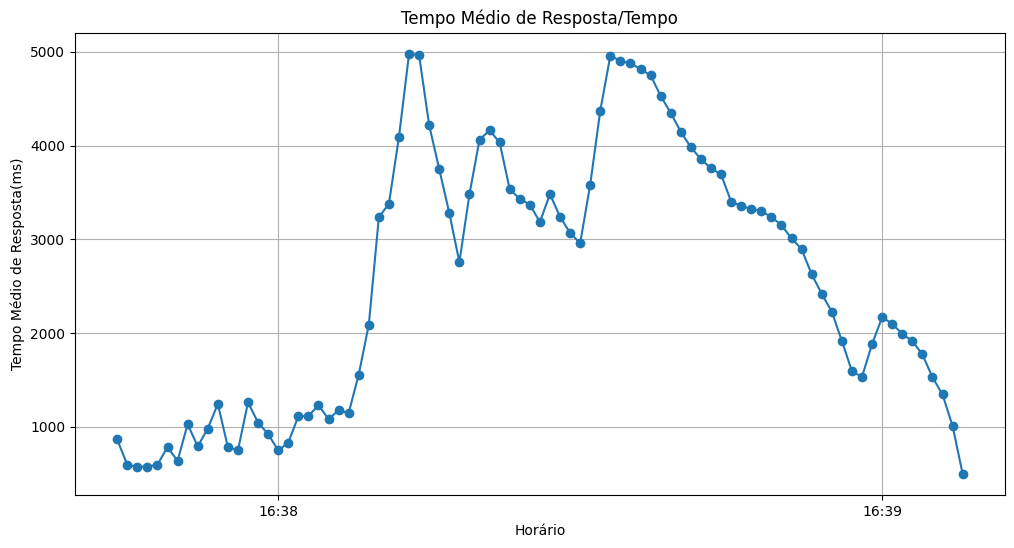

In [5]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Filtrar apenas o intervalo desejado (18:00 até 23:00)
dados_filtrados = dados_df[(dados_df['timeStamp_rounded'] >= '2023-11-18 10:00:00') & (dados_df['timeStamp_rounded'] <= '2023-11-24 23:59:00')]

# Análise de Tendências ao Longo do Tempo
grupo_timestamp = dados_filtrados.groupby('timeStamp_rounded')
mean_elapsed = grupo_timestamp['elapsed'].mean()
df_medias = mean_elapsed.reset_index()

# Plotar gráfico com intervalos de um minuto
plt.figure(figsize=(12, 6))
plt.plot(df_medias['timeStamp_rounded'] + pd.Timedelta(hours=0), df_medias['elapsed'], marker='o')
plt.title('Tempo Médio de Resposta/Tempo')
plt.xlabel('Horário')
plt.ylabel('Tempo Médio de Resposta(ms)')
plt.grid(True)

# Configurar formatação do eixo x para mostrar minutos
plt.gca().xaxis.set_major_locator(mdates.MinuteLocator(interval=1))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

plt.show()


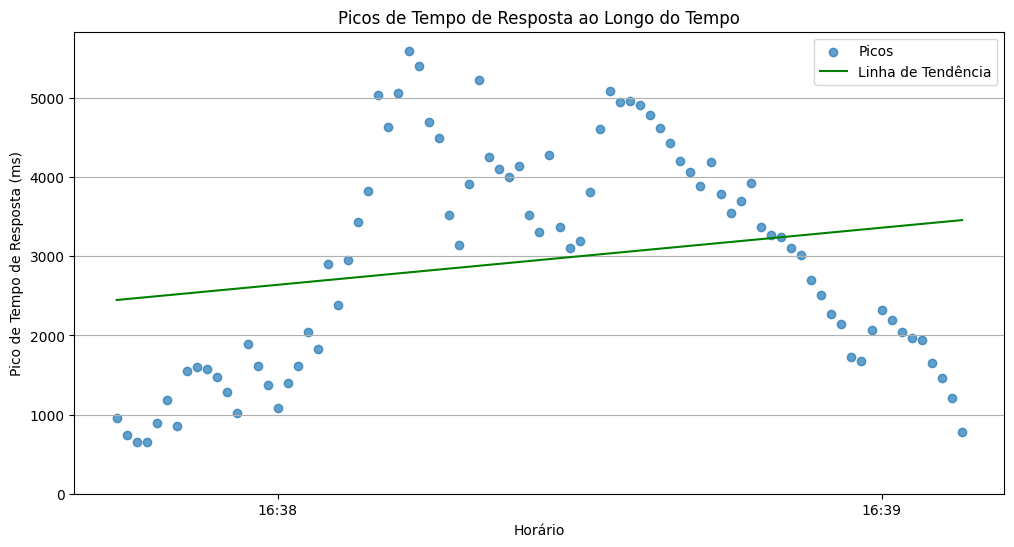

In [6]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np

# Filtrar apenas o intervalo desejado (18:00 até 23:00)
dados_filtrados = dados_df[(dados_df['timeStamp_rounded'] >= '2023-11-18 10:25:00') & (dados_df['timeStamp_rounded'] <= '2023-11-24 23:35:00')]

# Análise de Tendências ao Longo do Tempo
grupo_timestamp = dados_filtrados.groupby('timeStamp_rounded')
pico_elapsed = grupo_timestamp['elapsed'].max()
df_picos = pico_elapsed.reset_index()

# Calcular a linha de tendência usando numpy.polyfit
coefficients = np.polyfit(df_picos.index, df_picos['elapsed'], 1)
tendencia = np.polyval(coefficients, df_picos.index)

# Plotar gráfico de dispersão com picos e linha de tendência
plt.figure(figsize=(12, 6))
plt.scatter(df_picos['timeStamp_rounded'] - pd.Timedelta(hours=0), df_picos['elapsed'], label='Picos', alpha=0.7)
plt.plot(df_picos['timeStamp_rounded'] - pd.Timedelta(hours=0), tendencia, color='green', label='Linha de Tendência')
plt.title('Picos de Tempo de Resposta ao Longo do Tempo')
plt.xlabel('Horário')
plt.ylabel('Pico de Tempo de Resposta (ms)')
plt.grid(True, axis='y')
plt.legend()

# Configurar formatação do eixo x para mostrar minutos
plt.gca().xaxis.set_major_locator(mdates.MinuteLocator(interval=1))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

# Configurar o eixo y para começar de zero
plt.gca().set_ylim(bottom=0)

plt.show()


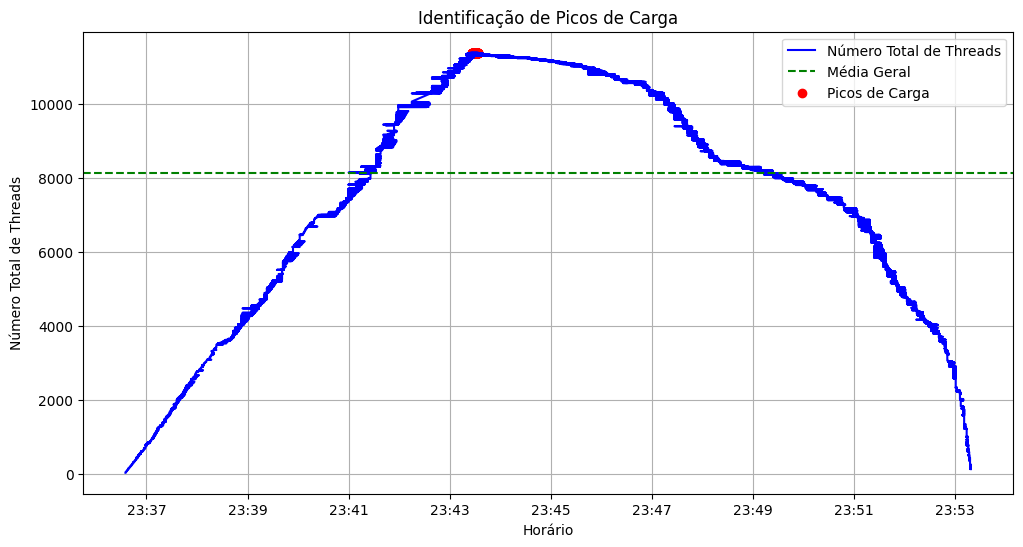

In [112]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, timedelta

# Identificação de Picos de Carga
plt.figure(figsize=(12, 6))

# Ajustar o fuso horário
dados_df['timeStamp_rounded'] = dados_df['timeStamp_rounded'] + timedelta(hours=3)

# Plotar a linha dos dados
plt.plot(dados_df['timeStamp_rounded'], dados_df['allThreads'], label='Número Total de Threads', color='blue')

# Adicionar uma linha para representar a média geral
media_geral = dados_df['allThreads'].mean()
plt.axhline(media_geral, linestyle='--', color='green', label='Média Geral')

# Identificar picos
picos = dados_df[dados_df['allThreads'] == dados_df['allThreads'].max()]
plt.scatter(picos['timeStamp_rounded'], picos['allThreads'], color='red', label='Picos de Carga')

plt.title('Identificação de Picos de Carga')
plt.xlabel('Horário')
plt.ylabel('Número Total de Threads')
plt.legend()
plt.grid(True)
# Configurar formatação do eixo x para mostrar minutos
plt.gca().xaxis.set_major_locator(mdates.MinuteLocator(interval=2))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.show()
